In [1]:
# imports 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
seed = 1
np.random.seed(seed)

plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['figure.dpi'] = 80

In [2]:
hidden_u = []
m = 200
dim = 2
bounds = [1.6, 4]
n_x = 6
n_y = 15
batch_n = n_x*n_y
buff = None
epochs = 2000
tol = 1e-5
sgd = tf.keras.optimizers.SGD(learning_rate=m*0.1, nesterov=True)
# van poole equation
def vf(x):
    y = [-x[:,1], x[:,0] - (1-x[:,0]**2)*x[:,1]]
    return y


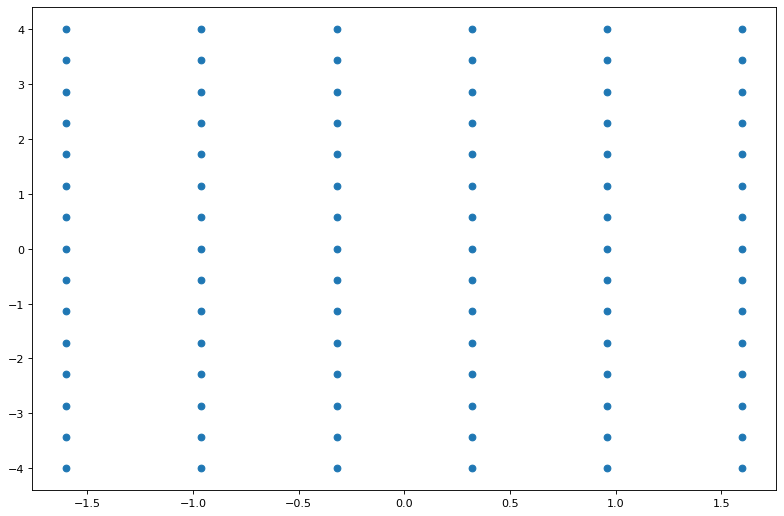

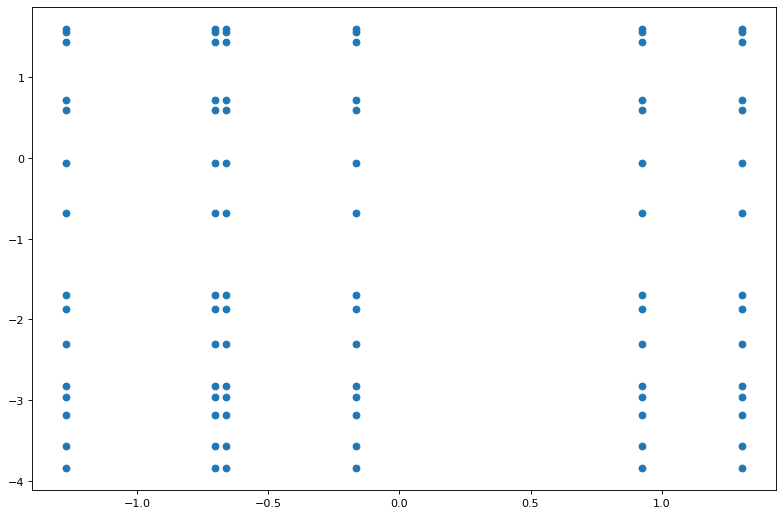

In [5]:
def create_dataset(n_x, n_y, dim, bounds, func, batch_n, buff = None, train = True, plot=False):
    if train == True:
        x = np.linspace(-bounds[0], bounds[0], n_x)
        y = np.linspace(-bounds[1], bounds[1], n_y)
    else:
        x = np.random.uniform(-bounds[0], bounds[0], n_x)
        y = np.random.uniform(-bounds[1], bounds[1], n_y)
    X, Y = np.meshgrid(x, y)
    s = X.shape
    data = np.zeros((n_x*n_y,dim)) 

    # convert mesh into point vector for which the model can be evaluated
    c = 0
    for i in range(s[0]):
        for j in range(s[1]):
            data[c,0] = X[i,j]
            data[c,1] = Y[i,j]
            c = c+1;
    data_points = tf.constant(data, tf.float32) # (n_y, dim)
                    
    input_RHS =  tf.transpose(tf.convert_to_tensor(func(data_points), dtype=tf.float32))  # (n_y, dim)

    dataset_raw = tf.data.Dataset.from_tensor_slices((data_points, input_RHS))
    if buff:
        dataset_raw = dataset_raw.shuffle(buffer_size=buff)
    dataset = dataset_raw.batch(batch_n)

    if plot:
        plt.scatter(data_points[:,0], data_points[:,1])
        plt.show()

    return dataset, data_points, input_RHS

train_dataset, _, _ = create_dataset(n_x, n_y, dim, bounds, vf, batch_n, plot=True)
test_dataset, _, _ = create_dataset(n_x, n_y, dim, bounds, vf, batch_n, train = False, plot = True)

In [19]:
def get_regularised_bn_mlp(input_shape, m, hidden_units, l2_reg_coeff = None, dropout_rate = None):
    """
    This function is used to build the MLP model. It takes input_shape and hidden_units
    as arguments, which should be used to build the model as described above, using the
    functional API.
    Your function should return the model.
    """
    inputs = tf.keras.layers.Input(shape=(input_shape,), name = 'state')
    h = tf.keras.layers.Dense(m, activation=tf.math.cos, 
                              kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=1),
                              bias_initializer= tf.random_uniform_initializer(0, 2*  np.pi), 
                              trainable=False, name = '1st_hidden')(inputs)
    # h = tf.keras.layers.Dense(m, activation=tf.math.cos, trainable=False, name = '1st_hidden')(inputs)
    h = np.sqrt(2) * h 
    for units in hidden_units:
        h = tf.keras.layers.Dense(units, activation='linear')(h)
    # use bias is false because the derivative of a constant number (bias) is just zero
    outputs = tf.keras.layers.Dense(1, kernel_initializer = tf.zeros_initializer(),activation=None, name = 'output_layer', use_bias=False, trainable=True)(h)
    outputs = outputs / m 
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

tf.random.set_seed(666)
model = get_regularised_bn_mlp(input_shape=dim, m = m, hidden_units= hidden_u)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 state (InputLayer)          [(None, 2)]               0         
                                                                 
 1st_hidden (Dense)          (None, 200)               600       
                                                                 
 tf.math.multiply_1 (TFOpLam  (None, 200)              0         
 bda)                                                            
                                                                 
 output_layer (Dense)        (None, 1)                 200       
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 1)                0         
 da)                                                             
                                                                 
Total params: 800
Trainable params: 200
Non-trainable param

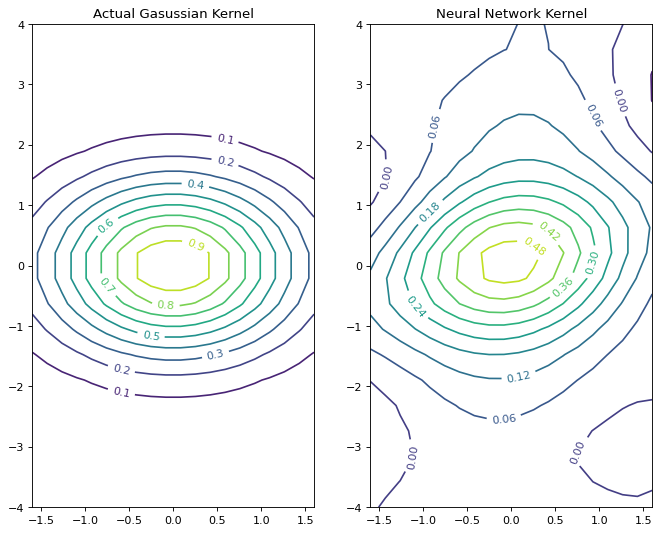

In [20]:
"""Simply plot the Layer without any training to see its initial state and compare with actual Gaussian kernel"""
n= 20
x = np.linspace(-bounds[0], bounds[0], n)
y = np.linspace(-bounds[1], bounds[1], n)

X, Y = np.meshgrid(x, y)

s = X.shape

Ze = np.zeros(s)
Zp = np.zeros(s)
DT = np.zeros((n**2,dim))

# convert mesh into point vector for which the model can be evaluated
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        DT[c,0] = X[i,j]
        DT[c,1] = Y[i,j]
        c = c+1;

intermediate_output1 = tf.keras.Model(model.input, model.get_layer('1st_hidden').output)

x1 = tf.zeros(DT.shape, tf.float32) # (n**2, 2)
x2 = tf.constant(DT, tf.float32) # (n**2, 2)
phi_1 = intermediate_output1(x1) # (n**2, m)
phi_2 = intermediate_output1(x2) # (n**2, m)
k_nn = tf.reduce_sum(phi_1*phi_2, axis=1) / m # (n**2,) Eq. 22 paper
k_nn = tf.reshape(k_nn, (n, n)) # (n, n)

g_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic()
kernel_sol = g_kernel.apply(x1, x2) # (n**2,)
kernel_sol = tf.reshape(kernel_sol, (n,n)) # (n,n)

plt.figure(figsize=(10, 8))
plt.subplot(121)
plt.title('Actual Gasussian Kernel')
cp1 = plt.contour(x,y, kernel_sol, levels=10)
plt.clabel(cp1, inline=True, fontsize=10)

plt.subplot(122)
plt.title('Neural Network Kernel')
cp2 = plt.contour(x,y, k_nn, levels=10)
plt.clabel(cp2, inline=True, fontsize=10)
plt.show()

In [21]:
@tf.function
def train_step(x_batch_train, vf_batch_train):
  """
  x_batch_train: (n,2)
  vf_batch_train: (n,2)
  """

# start gradient recording for derivative w.r.t. model parameters
  with tf.GradientTape() as tape:
    with tf.GradientTape() as tapex:
      # prepare for evaluation of x-derivative
      tapex.watch(x_batch_train)
      logits2 = model(x_batch_train) # (n, 1)

    # evaluate x-derivative
    gradx = tapex.gradient(logits2, x_batch_train) # (n,2)

    # evaluate PDE part of loss function

    inner_product = tf.reduce_sum(gradx*vf_batch_train, axis=1) # (n,)
    target = tf.square(tf.norm(x_batch_train, ord = 2, axis=1)) # (n,)
    individual_loss = tf.square(tf.abs((inner_product + target))) # (n,)
    loss_value = tf.reduce_sum(individual_loss) / len(x_batch_train) # scalar

  # evaluate derivative w.r.t. model parameters
  # changed this
  grads = tape.gradient(loss_value, model.trainable_weights) # (m, 1)

  # Run one step of gradient descent optimizer
  sgd.apply_gradients(zip(grads, model.trainable_weights))

  return(loss_value)

@tf.function
def test_step(x_test, vf_test):

  with tf.GradientTape() as tapex:

    tapex.watch(x_test)
    # not sure if training should be false here.
    logits2 = model(x_test)

  # evaluate x-derivative
  gradx = tapex.gradient(logits2, x_test)
  inner_product = tf.reduce_sum(gradx*vf_test, axis=1) # (n,)
  target = tf.square(tf.norm(x_test, ord = 2, axis=1)) # (n,)
  individual_loss = tf.square(tf.abs((inner_product + target))) # (n,)
  loss_value = tf.reduce_sum(individual_loss) / len(x_test) # scalar
  return loss_value

In [22]:
def custom_training_loop(epochs, tol, train_dataset, validation_dataest):

    all_loss_values = []
    all_test_loss_values = []

    # loop through the epochs
    for epoch in range(epochs):
        
        # Iterate over the batches of the dataset
        # in our case only 1 batch so inly 1 loop here
        for _, (x_batch_train, vf_batch_train) in enumerate(train_dataset):

            # call optimization routine
            loss_value = train_step(x_batch_train, vf_batch_train)
            all_loss_values.append(loss_value.numpy())

        for _, (x_test, vf_test) in enumerate(validation_dataest):
            test_loss = test_step(x_test, vf_test)
            all_test_loss_values.append(test_loss)

        if epoch % int(epochs/5) == 0:
            print('epoch %2s, loss %10.6f' % (epoch, float(loss_value)))
            
    return all_loss_values, all_test_loss_values

In [23]:
all_loss_values, all_test_loss_values = custom_training_loop(epochs, tol, train_dataset, test_dataset)

epoch  0, loss  83.510109
epoch 400, loss   2.392425


2022-07-19 18:15:33.156361: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


epoch 800, loss   1.844743
epoch 1200, loss   1.685638
epoch 1600, loss   1.601024


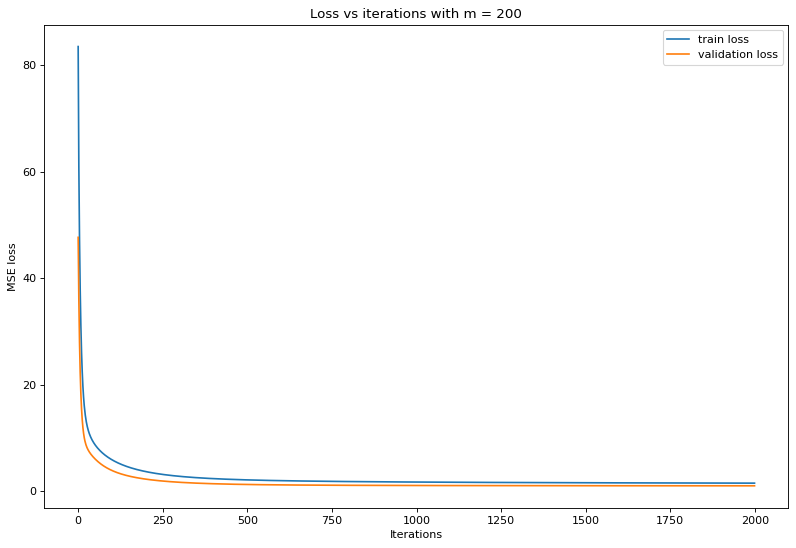

In [24]:
plt.plot(all_loss_values, label = 'train loss')
# plt.xscale('log')
plt.plot(all_test_loss_values, label = 'validation loss')
plt.title("Loss vs iterations with m = {}".format(m))
plt.xlabel("Iterations")
plt.ylabel("MSE loss")
plt.legend()
# plt.xscale('log')
plt.show()

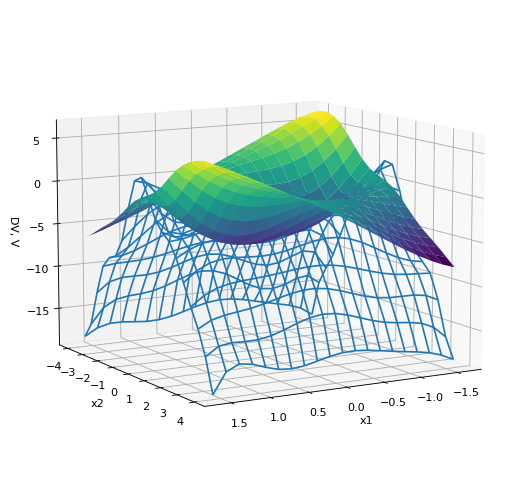

In [25]:
###### plot result ######

# define resolution
numpoints = 20

# define plotting range and mesh
x = np.linspace(-bounds[0], bounds[0], numpoints)
y = np.linspace(-bounds[1], bounds[1], numpoints)

X, Y = np.meshgrid(x, y)

s = X.shape

Ze = np.zeros(s)
Zp = np.zeros(s)
DT = np.zeros((numpoints**2,dim))

# convert mesh into point vector for which the model can be evaluated
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        DT[c,0] = X[i,j]
        DT[c,1] = Y[i,j]
        c = c+1;

# evaluate model (= Lyapunov function values V)
Ep = model.predict(DT)
intermediate_output2 = tf.keras.Model(model.input, model.get_layer('output_layer').output)


# convert point vector to tensor for evaluating x-derivative
tDT = tf.convert_to_tensor(DT, dtype=tf.float32)

# evaluate gradients DV of Lyapunov function
with tf.GradientTape() as tape:
    tape.watch(tDT)
    ypm = model(tDT)
    grads = tape.gradient(ypm, tDT)

# compute orbital derivative DVf
Ee = tf.math.reduce_sum(grads*tf.transpose(tf.convert_to_tensor(vf(DT), dtype=tf.float32)), axis=1)

# copy V and DVf values into plottable format
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        Ze[i,j] = Ee[c]
        Zp[i,j] = Ep[c]
        c = c+1;


# define vector field for plot
new_vf = np.reshape(np.array(vf(DT)), (dim, numpoints, numpoints))

# define figure
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

# ax.set_title('m = {}'.format(m))
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('DV, V');

# plot values V
ax.plot_surface(X, Y, Zp, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

# plot orbital derivative DVf
ax.plot_wireframe(X, Y, Ze, rstride=1, cstride=1)

# change angles to see graph more clearly
# ax.view_init(-140, 60)
ax.view_init(10, 60)

# plt.savefig('Plots/van_3dplot.pdf')
plt.show()

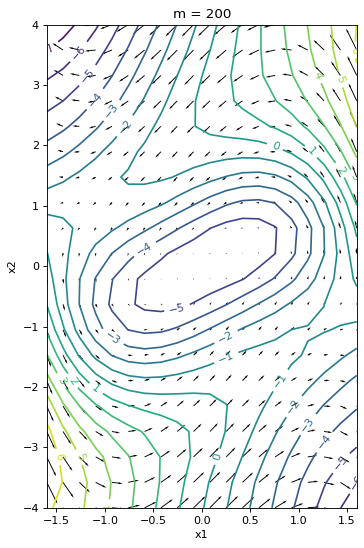

In [26]:
plt.figure(figsize=(5,8))
cp = plt.contour(x,y,Zp, levels=15)
plt.quiver(X,Y, new_vf[0], new_vf[1], headwidth=2, headlength=4)
plt.clabel(cp, inline=True, fontsize=10)
plt.title('m = {}'.format(m))
plt.xlabel('x1')
plt.ylabel('x2')
# plt.savefig('Plots/vanpol2.pdf')
plt.show()

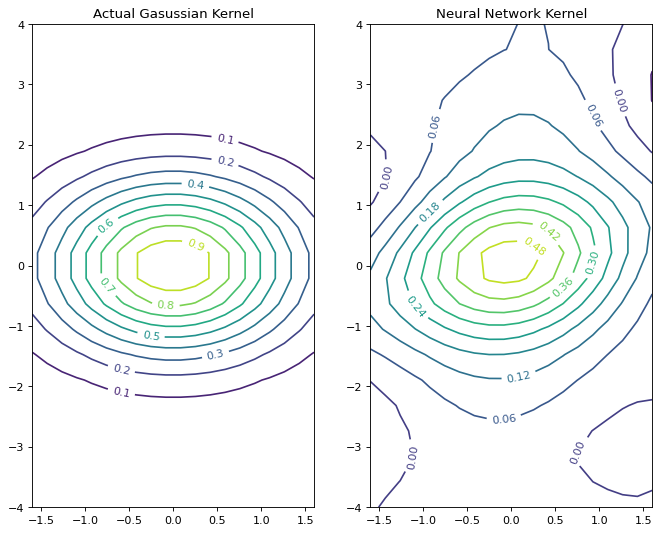

In [27]:
"""Simply plot the Layer without any training to see its initial state and compare with actual Gaussian kernel"""
n= 20
x = np.linspace(-bounds[0], bounds[0], n)
y = np.linspace(-bounds[1], bounds[1], n)

X, Y = np.meshgrid(x, y)

s = X.shape

Ze = np.zeros(s)
Zp = np.zeros(s)
DT = np.zeros((n**2,dim))

# convert mesh into point vector for which the model can be evaluated
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        DT[c,0] = X[i,j]
        DT[c,1] = Y[i,j]
        c = c+1;

intermediate_output1 = tf.keras.Model(model.input, model.get_layer('1st_hidden').output)

x1 = tf.zeros(DT.shape, tf.float32) # (n**2, 2)
x2 = tf.constant(DT, tf.float32) # (n**2, 2)
phi_1 = intermediate_output1(x1) # (n**2, m)
phi_2 = intermediate_output1(x2) # (n**2, m)
k_nn = tf.reduce_sum(phi_1*phi_2, axis=1) / m # (n**2,) Eq. 22 paper
k_nn = tf.reshape(k_nn, (n, n)) # (n, n)

g_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic()
kernel_sol = g_kernel.apply(x1, x2) # (n**2,)
kernel_sol = tf.reshape(kernel_sol, (n,n)) # (n,n)

plt.figure(figsize=(10, 8))
plt.subplot(121)
plt.title('Actual Gasussian Kernel')
cp1 = plt.contour(x,y, kernel_sol, levels=10)
plt.clabel(cp1, inline=True, fontsize=10)

plt.subplot(122)
plt.title('Neural Network Kernel')
cp2 = plt.contour(x,y, k_nn, levels=10)
plt.clabel(cp2, inline=True, fontsize=10)
plt.show()